In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Matplotlib is building the font cache; this may take a moment.


In [45]:
# 读取CSV文件
df = pd.read_csv('../bitcoin_price_sentiment.csv')

# 确保日期列是datetime格式
df['date'] = pd.to_datetime(df['date'])

# 准备 XGBoost 所需的数据框
#xgboost_df = df[['date', 'Close']].rename(columns={'date': 'ds', 'Close': 'y'})

# prophet_df = df[['date', 'Close', 'sentiment_scores']].rename(columns={'date': 'ds', 'Close': 'y'})

df['lag1'] = df['Close'].shift(1)
df['lag2'] = df['Close'].shift(2)

# 添加其他特征作为回归变量
features = ['Open', 'High', 'Low', 'Volume', 'sentiment_scores', 'lag1', 'lag2']
X = df[features]
y = df['Close']

#features = ['sentiment_scores']

# 标准化特征
# scaler = StandardScaler()
# df[features] = scaler.fit_transform(df[features])

# 将特征添加到prophet_df
# for feature in features:
#     prophet_df[feature] = df[feature]

# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [82]:
import pandas as pd

# 假设你的数据已经加载到一个 DataFrame 中，并且包含 'Close' 列和 'Date' 列
data = pd.read_csv('../bitcoin_price_sentiment.csv')

# 确保日期列是datetime格式
data['date'] = pd.to_datetime(data['date'])

data['lag1'] = data['Close'].shift(1)
data['lag2'] = data['Close'].shift(2)

data = data.dropna()

print(data.head())
# 计算划分点，取前 70% 的数据作为训练集
train_size = int(len(data) * 0.8)

# 使用前 70% 的数据作为训练集，后 30% 的数据作为测试集
train = data[:train_size]
test = data[train_size:]

# 检查训练集和测试集大小
print(f"Training data size: {len(train)}")
print(f"Testing data size: {len(test)}")

# 训练集特征和目标
X_train = train[['Open', 'High', 'Low', 'Volume', 'sentiment_scores', 'lag1', 'lag2']]  # 假设这是你的特征列
y_train = train['Close']  # 收盘价作为目标值

# 测试集特征和目标
X_test = test[['Open', 'High', 'Low', 'Volume', 'sentiment_scores', 'lag1', 'lag2']]
y_test = test['Close']

        date      Open      High       Low     Close     Volume  \
2 2021-02-07  38371.71  38371.71  38319.25  38319.25   2.961660   
3 2021-02-08  42739.45  42739.45  42661.76  42705.78   1.481081   
4 2021-02-09  47062.03  47097.63  47015.62  47072.73  23.373384   
5 2021-02-10  45207.21  45210.00  45140.46  45144.15   1.940480   
6 2021-02-13  46829.35  46844.53  46787.05  46839.50   3.338138   

   sentiment_scores      lag1      lag2  
2          0.140346  40341.59  37423.85  
3          0.155133  38319.25  40341.59  
4          0.149979  42705.78  38319.25  
5          0.159520  47072.73  42705.78  
6          0.155729  45144.15  47072.73  
Training data size: 176
Testing data size: 44


In [83]:
# 转换为 DMatrix 格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [139]:
# 设置 XGBoost 参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'max_depth': 100,                   # 决策树的最大深度
    'eta': 0.05,                       # 学习率
    'subsample': 0.9,                 # 随机采样比例
    'colsample_bytree': 0.9           # 每棵树的特征随机采样比例
}

num_round = 1000  # 训练轮次

In [140]:
# 训练模型
bst = xgb.train(params, dtrain, num_boost_round=num_round)

In [141]:
from sklearn.metrics import mean_squared_error

# 对测试集进行预测
y_pred = bst.predict(dtest)

# 计算均方误差 (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"均方误差: {mse}")

均方误差: 904275.3852728053


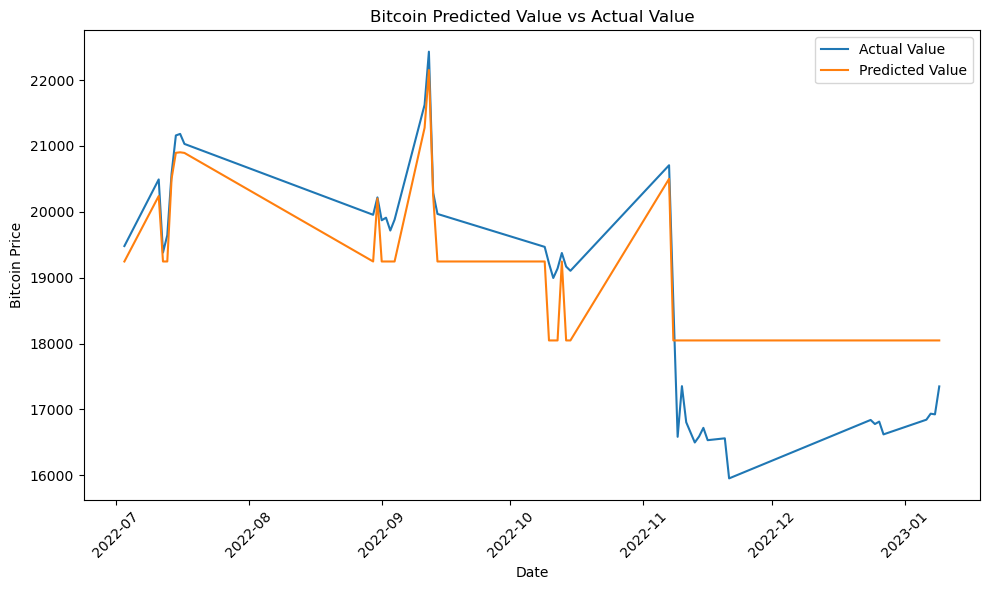

In [142]:
# 可视化实际值和预测值
plt.figure(figsize=(10, 6))
# 绘制真实值
plt.plot(test['date'], y_test, label='Actual Value')

# 绘制预测值
plt.plot(test['date'], y_pred, label='Predicted Value')

# 设置 x 轴为日期
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Predicted Value vs Actual Value')

# 显示图例
plt.legend()

# 显示图表
plt.xticks(rotation=45)  # 旋转日期标签，避免重叠
plt.tight_layout()
plt.show()

12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing


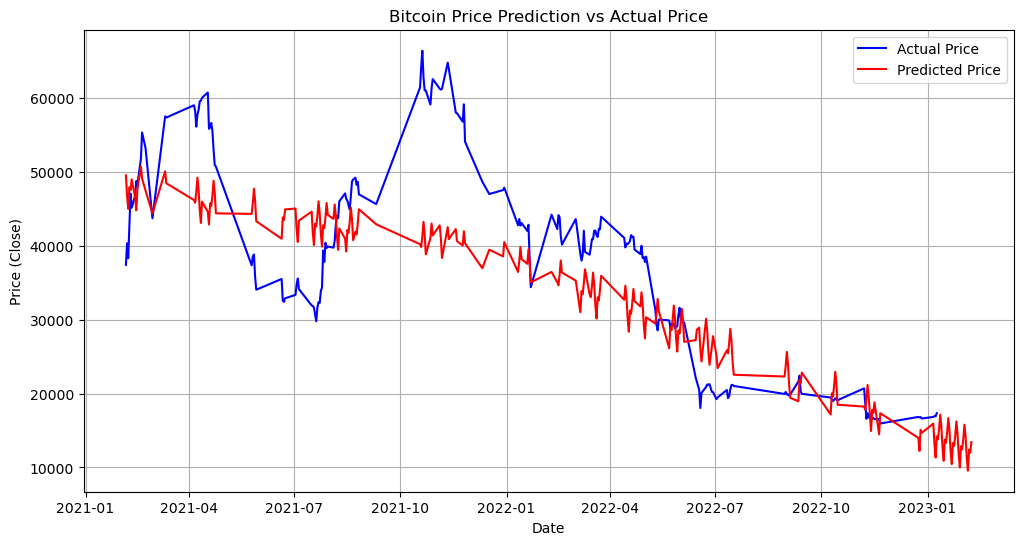

In [29]:
# 创建Prophet模型
model = Prophet()

# 添加所有特征作为回归变量
for feature in features:
    model.add_regressor(feature)

# 训练模型
model.fit(prophet_df)

# 创建未来30天的日期范围
future_dates = model.make_future_dataframe(periods=30)

# 为未来日期添加特征值
# 这里我们使用最后一个已知的值，你可能需要根据实际情况调整这个逻辑
for feature in features:
    future_dates[feature] = df[feature].iloc[-1]

# 进行预测
forecast = model.predict(future_dates)

# 读取预测结果中的 ds（日期）和 yhat（预测值）字段
forecast_filtered = forecast[['ds', 'yhat']]

# 将实际价格数据与预测结果合并
df_merged = pd.merge(forecast_filtered, prophet_df, on='ds', how='left')

# 绘制实际价格和预测价格的对比图
plt.figure(figsize=(12, 6))

# 画出实际价格的折线图
plt.plot(df_merged['ds'], df_merged['y'], label='Actual Price', color='blue')

# 画出预测价格的折线图
plt.plot(df_merged['ds'], df_merged['yhat'], label='Predicted Price', color='red')

# 添加图例和标题
plt.legend()
plt.title('Bitcoin Price Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Price (Close)')
plt.grid(True)
plt.show()

In [30]:
# 预测已知的历史数据
historical_forecast = model.predict(prophet_df)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 获取实际值和预测值
y_true = prophet_df['y'].values  # 实际值
y_pred = historical_forecast['yhat'].values  # 预测值

# 计算均方误差 (MSE)
mse = mean_squared_error(y_true, y_pred)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mse)

# 计算平均绝对误差 (MAE)
mae = mean_absolute_error(y_true, y_pred)

# 计算决定系数 R²
r2 = r2_score(y_true, y_pred)

# 打印结果
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

MSE: 60980869.95193458
RMSE: 7809.02490404113
MAE: 5980.871868771956
R²: 0.6777939846865725
